In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from matplotlib.image import imread
import cv2
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Helper Functions

In [2]:
def get_image_arrays(data, label, img_size):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays
    print("Nicely Done!")

In [3]:
#plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate lass curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss=history.history["val_loss"]
  
  accuracy=history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  
  epochs = range(len(history.history["loss"]))# how many epochs did we run for?

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("model loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("model accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [4]:
def normalize_image_arrays(data, label, img_size):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), (img_size,img_size), interpolation = cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays
    print("Nicely Done!")


In [5]:
#confusion matrix function to visualize it
def visualize_conf_mat(true_labels, predicted_labels):
  '''
  Visualize confusion matrix also in percentage.
  '''
  predicted_classes = np.argmax(predicted_labels, axis = 1) 
  # create subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # plot confusion matrix
  confusion_mtx = confusion_matrix(true_labels, predicted_classes) 
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt= '.1f', ax=ax1)
  ax1.set_xlabel("Predicted Label")
  ax1.set_ylabel("True Label")
  ax1.set_title("Confusion Matrix")

  # plot confusion matrix percentage
  confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100
  sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax2)
  ax2.set_xlabel("Predicted Label")
  ax2.set_ylabel("True Label")
  ax2.set_title("Confusion Matrix (Percentage)")

  plt.show()

In [6]:
def img_pred(arr,test_arr,index,model):
    plt.title('Test Image')
    plt.imshow(arr[index])
    input = arr[index:index+1]
    pred = model.predict(input)[0].argmax()
    label = test_arr[index].argmax()
    print('Predicted Value Using CNN Model:',pred)
    print("True Value:",label)

### Get Data

In [7]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for filename in breast_img[:10]:
    print(filename)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
/kaggle/input/breast-histopathology-images/IDC_

In [8]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in breast_img:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [9]:
len(class0),len(class1)

(198738, 78786)

### Visualize Data

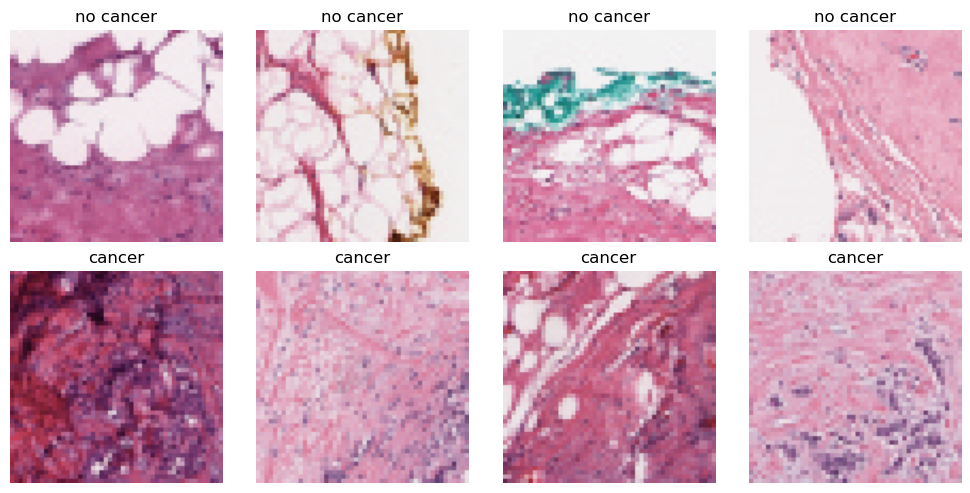

In [10]:
plt.figure(figsize=(10, 5))

some_non_img = np.random.choice(class0, size=4, replace=False)
some_can_img = np.random.choice(class1, size=4, replace=False)

for i in range(4):
    img_non = image.load_img(some_non_img[i], target_size=(100, 100))
    img_can = image.load_img(some_can_img[i], target_size=(100, 100))

    img_non = image.img_to_array(img_non)
    img_can = image.img_to_array(img_can)

    plt.subplot(2, 4, i + 1)
    plt.axis('off')
    plt.title('no cancer')
    plt.imshow(img_non.astype('uint8'))

    plt.subplot(2, 4, i + 5)
    plt.axis('off')
    plt.title('cancer')
    plt.imshow(img_can.astype('uint8'))

plt.tight_layout()
plt.show()


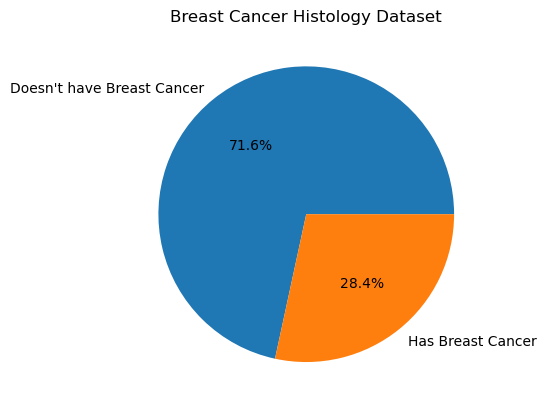

In [11]:
neg_count = len(class0)
pos_count =  len(class1)

counts = [neg_count, pos_count]
labels = ['Doesn\'t have Breast Cancer', 'Has Breast Cancer']

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Breast Cancer Histology Dataset')
plt.show()

### Get Data Ready For Models

As you see below our dataset is not balanced. So I decide to choose random 30000 image from each class.

In [12]:
random.seed(42)
new_class0 = random.sample(class0, 30000)
new_class1 = random.sample(class1, 30000)
len(new_class0), len(new_class1)

(30000, 30000)

#### Original Data

In [13]:
neg_or_img_arr = get_image_arrays(new_class0, 0, 50) # Negative IDC(-)
pos_or_img_arr = get_image_arrays(new_class1, 1, 50) # Positive IDC(+)

In [14]:
print(len(neg_or_img_arr))
print(len(pos_or_img_arr))
print(len(neg_or_img_arr)+len(pos_or_img_arr))

30000
30000
60000


In [15]:
X = []
y = []

breast_or_img_arr = neg_or_img_arr + pos_or_img_arr
random.shuffle(breast_or_img_arr)

for feature, label in breast_or_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [16]:
print('Total number of images: {}'.format(len(X)))
print('Number of Non Cancer Images: {}'.format(np.sum(y==0)))
print('Number of Cancer Images: {}'.format(np.sum(y==1)))
print('Image shape (Width, Height, Channels): {}'.format(X[0].shape))

Total number of images: 60000
Number of Non Cancer Images: 30000
Number of Cancer Images: 30000
Image shape (Width, Height, Channels): (50, 50, 3)


#### Normalize Data

In [17]:
neg_nor_img_arr = normalize_image_arrays(new_class0, 0, 50) # Negative IDC(-)
pos_nor_img_arr = normalize_image_arrays(new_class1, 1, 50) # Positive IDC(+)

In [18]:
print(len(neg_nor_img_arr))
print(len(pos_nor_img_arr))
print(len(neg_nor_img_arr)+len(pos_nor_img_arr))

30000
30000
60000


In [19]:
X_nor = []
y_nor = []

breast_nor_img_arr = neg_nor_img_arr+pos_nor_img_arr
random.shuffle(breast_nor_img_arr)

for feature, label in breast_nor_img_arr:
    X_nor.append(feature)
    y_nor.append(label)
    
X_nor = np.array(X_nor)
y_nor = np.array(y_nor)

In [20]:
print('Total number of images: {}'.format(len(X_nor)))
print('Number of Non Cancer Images: {}'.format(np.sum(y_nor==0)))
print('Number of Cancer Images: {}'.format(np.sum(y_nor==1)))
print('Image shape (Width, Height, Channels): {}'.format(X_nor[0].shape))

Total number of images: 60000
Number of Non Cancer Images: 30000
Number of Cancer Images: 30000
Image shape (Width, Height, Channels): (50, 50, 3)


##### One example of how different Original Data Array and Normalized Data Array

In [21]:
breast_or_img_arr[100]

[array([[[171, 133, 183],
         [161, 125, 170],
         [189, 158, 204],
         ...,
         [184, 165, 223],
         [219, 209, 233],
         [218, 206, 230]],
 
        [[154, 122, 160],
         [162, 132, 175],
         [185, 156, 198],
         ...,
         [193, 169, 227],
         [193, 171, 219],
         [195, 174, 224]],
 
        [[191, 170, 213],
         [161, 121, 179],
         [180, 146, 182],
         ...,
         [148, 119, 218],
         [207, 195, 234],
         [197, 185, 219]],
 
        ...,
 
        [[161, 117, 165],
         [168, 130, 176],
         [175, 137, 186],
         ...,
         [180, 151, 190],
         [180, 150, 201],
         [195, 177, 227]],
 
        [[155, 113, 153],
         [153, 117, 159],
         [166, 127, 171],
         ...,
         [196, 175, 223],
         [185, 160, 217],
         [187, 156, 206]],
 
        [[161, 119, 163],
         [172, 135, 182],
         [172, 137, 186],
         ...,
         [204, 184, 226],
  

In [22]:
breast_nor_img_arr[100]

[array([[[0.7370892 , 0.629108  , 0.7934272 ],
         [0.93896717, 0.92018783, 0.96713614],
         [0.91549295, 0.8920188 , 0.93896717],
         ...,
         [0.600939  , 0.41314554, 0.66197187],
         [0.45070425, 0.23004696, 0.5164319 ],
         [0.59624416, 0.3943662 , 0.8028169 ]],
 
        [[0.943662  , 0.92018783, 0.96713614],
         [0.971831  , 0.9624413 , 0.971831  ],
         [0.97652584, 0.9624413 , 0.9859155 ],
         ...,
         [0.5680751 , 0.34741786, 0.64319247],
         [0.629108  , 0.4178404 , 0.71361506],
         [0.53051645, 0.3286385 , 0.69953054]],
 
        [[0.92957747, 0.887324  , 0.943662  ],
         [0.971831  , 0.96713614, 0.97652584],
         [0.96713614, 0.9624413 , 0.97652584],
         ...,
         [0.42723006, 0.21596244, 0.46009392],
         [0.65258217, 0.45539907, 0.7840376 ],
         [0.45070425, 0.23474179, 0.64319247]],
 
        ...,
 
        [[0.9014085 , 0.8262911 , 0.91549295],
         [0.80751175, 0.70422536, 0.87793

### Split Data İnto Train, Validation and Test

#### Original Data

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (42000, 50, 50, 3)
Validation Data Shape: (9000, 50, 50, 3)
Testing Data Shape: (9000, 50, 50, 3)


In [24]:
# Save the arrays as separate files
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_val.npy', y_val)

#### Normalize Data

In [25]:
from sklearn.model_selection import train_test_split
X_train_nor, X_test_nor, y_train_nor, y_test_nor = train_test_split(X_nor, y_nor, test_size=0.3)
X_val_nor, X_test_nor, y_val_nor, y_test_nor = train_test_split(X_test_nor, y_test_nor, test_size=0.5)

from tensorflow.keras.utils import to_categorical
y_train_nor = to_categorical(y_train_nor, num_classes = 2)
y_val_nor = to_categorical(y_val_nor, num_classes = 2)
y_test_nor = to_categorical(y_test_nor, num_classes = 2)

print("Training Data Shape:", X_train_nor.shape)
print("Validation Data Shape:", X_val_nor.shape)
print("Testing Data Shape:", X_test_nor.shape)

Training Data Shape: (42000, 50, 50, 3)
Validation Data Shape: (9000, 50, 50, 3)
Testing Data Shape: (9000, 50, 50, 3)


In [26]:
# Save the arrays as separate files
np.save('X_train_nor.npy', X_train_nor)
np.save('X_test_nor.npy', X_test_nor)
np.save('X_val_nor.npy', X_val_nor)
np.save('y_train_nor.npy', y_train_nor)
np.save('y_test_nor.npy', y_test_nor)
np.save('y_val_nor.npy', y_val_nor)

### Model 1

In [27]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(24, activation='relu', kernel_initializer='he_uniform'),
    Dense(2, activation='softmax')
])

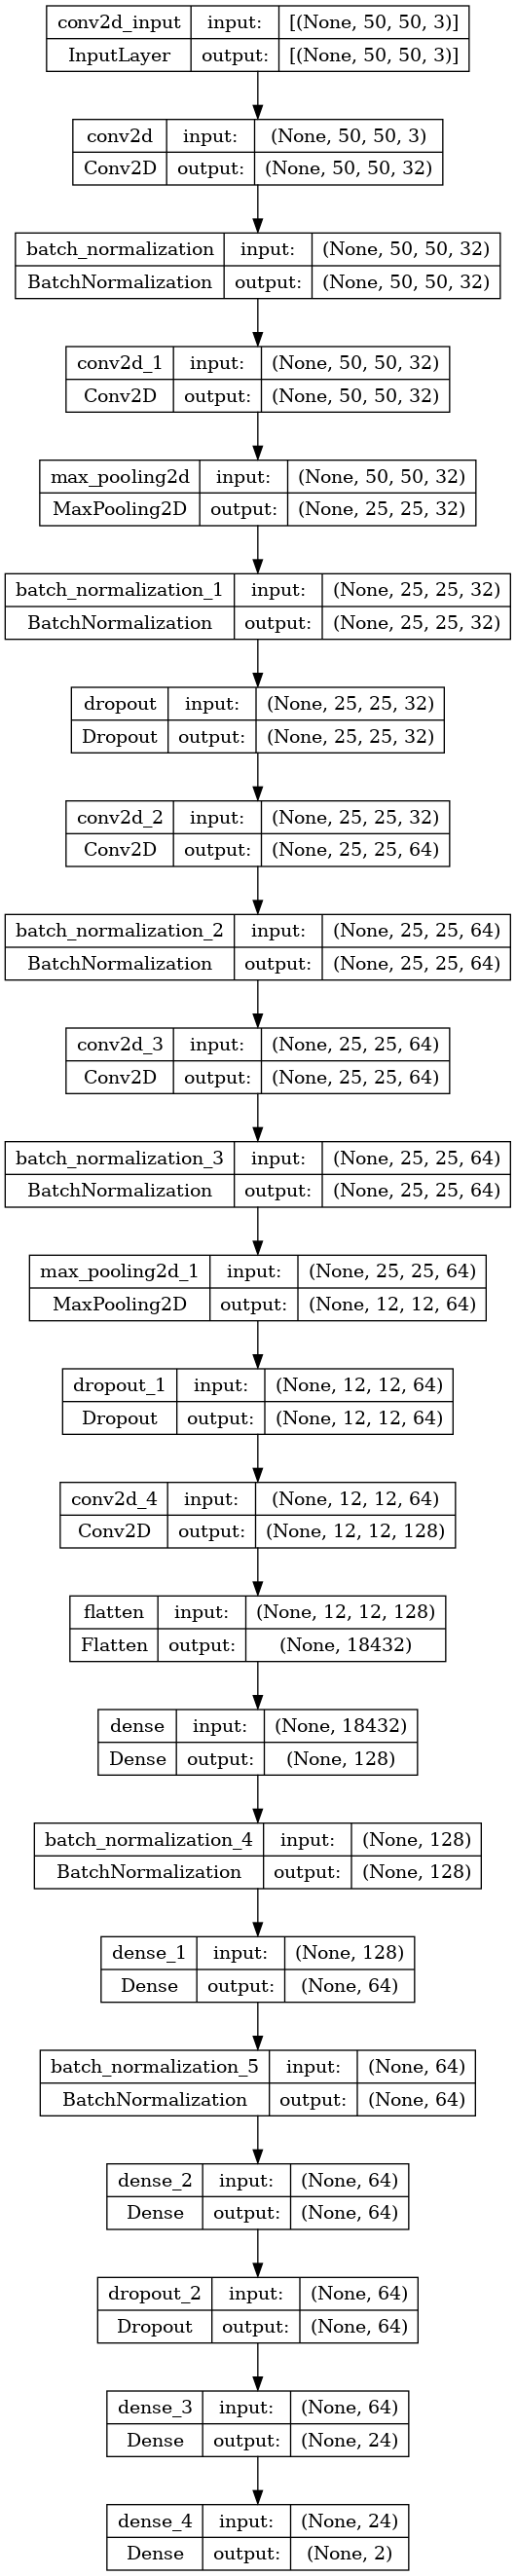

In [28]:
plot_model(model_1, to_file='model_1_hist.png', show_shapes=True)

#### Compile Model 1

In [29]:
model_1.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#### Fit Model 1 on Original Train Data

In [30]:
callbacks_or_1 = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),ModelCheckpoint('model_or_1.hdf5',save_best_only=True)]

In [31]:
%time
history_1_or = model_1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 35, callbacks=callbacks_or_1)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.34 µs
Epoch 1/20


2023-06-14 08:47:43.123746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 35s 15ms/step - loss: 0.4775 - accuracy: 0.7958 - val_loss: 0.4904 - val_accuracy: 0.7903
Epoch 2/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.4118 - accuracy: 0.8240 - val_loss: 0.4360 - val_accuracy: 0.8168
Epoch 3/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3960 - accuracy: 0.8301 - val_loss: 0.5162 - val_accuracy: 0.7623
Epoch 4/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3832 - accuracy: 0.8361 - val_loss: 0.4739 - val_accuracy: 0.7797
Epoch 5/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3766 - accuracy: 0.8396 - val_loss: 0.4571 - val_accuracy: 0.8054
Epoch 6/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3692 - accuracy: 0.8432 - val_loss: 0.4059 - val_accuracy: 0.8246
Epoch 7/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3592 - accuracy: 0.8482 - val_loss: 0.4366 - val_accura

#### Evaluate Model 1 on Original Test Data

In [32]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

282/282 [==============================] - 2s 6ms/step - loss: 0.4189 - accuracy: 0.8264
Test Loss: 0.41894346475601196
Test Accuracy: 0.8264444470405579


#### Original Data Results Visualization

##### Train

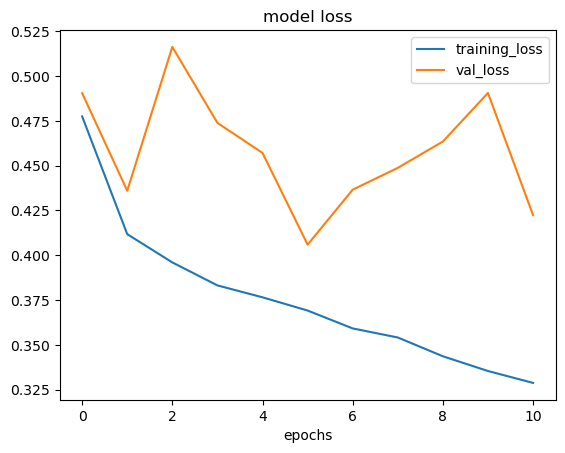

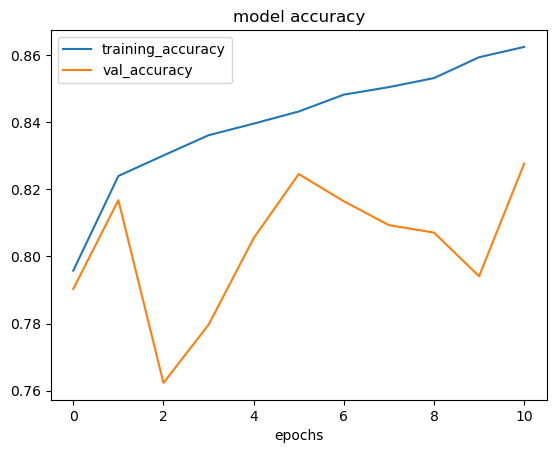

In [33]:
plot_loss_curves(history_1_or) # Plot our first history and see what happens on training process

##### Prediction

1/1 [==============================] - 0s 125ms/step
Predicted Value Using CNN Model: 1
True Value: 1


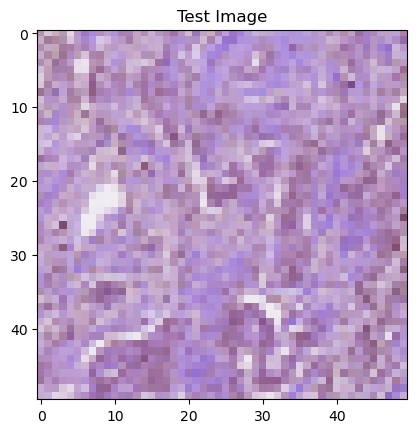

In [34]:
y_pred_1_or = model_1.predict(X_test) # Original test data prediction
y_true_1_or = np.argmax(y_test,axis = 1) # Original test data label
img_pred(X_test,y_test,2000,model_1) # Let's see one random prediction on original test data

1/1 [==============================] - 0s 24ms/step
Predicted Value Using CNN Model: 0
True Value: 0


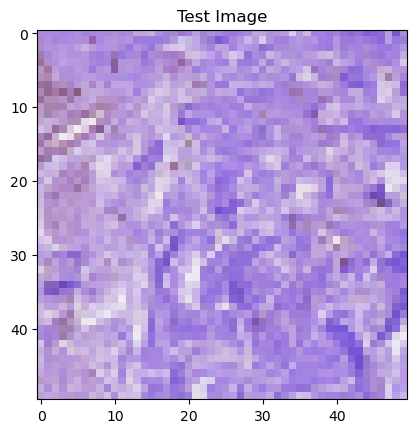

In [35]:
img_pred(X_test,y_test,6003,model_1)

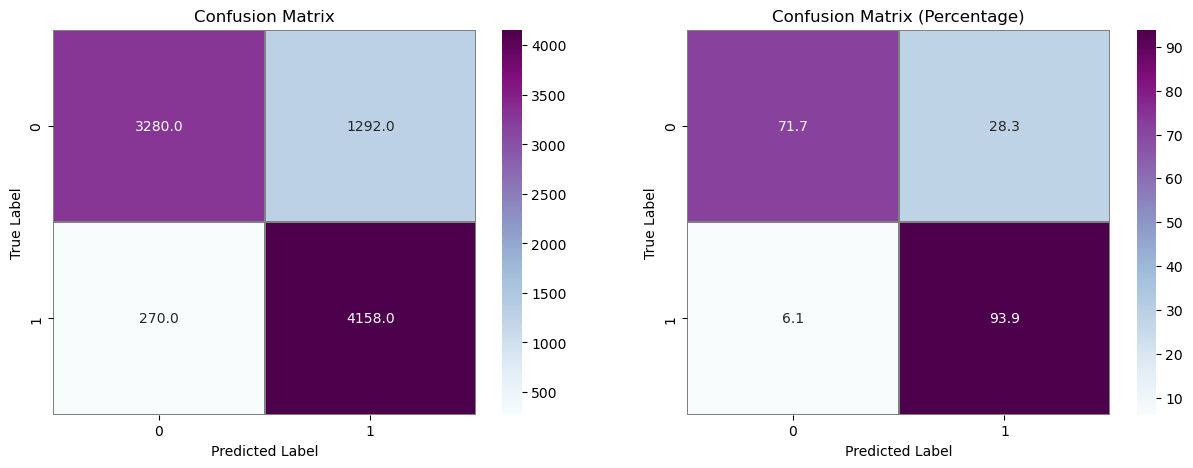

In [36]:
visualize_conf_mat(y_true_1_or,y_pred_1_or) # Let's visualize confusion matrix

In [37]:
print(classification_report(y_true_1_or, np.argmax(y_pred_1_or,axis = 1)))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      4572
           1       0.76      0.94      0.84      4428

    accuracy                           0.83      9000
   macro avg       0.84      0.83      0.82      9000
weighted avg       0.84      0.83      0.82      9000



#### Fit Model 1 on Normalized Train Data

In [38]:
callbacks_nor_1 = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),ModelCheckpoint('model_1_nor.hdf5',save_best_only=True)]

In [39]:
%time
history_1_nor = model_1.fit(X_train_nor, y_train_nor, validation_data = (X_val_nor, y_val_nor), epochs = 20, batch_size = 35, callbacks=callbacks_nor_1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Epoch 1/20


2023-06-14 08:52:21.526052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 20s 16ms/step - loss: 0.3636 - accuracy: 0.8468 - val_loss: 0.4289 - val_accuracy: 0.8083
Epoch 2/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3483 - accuracy: 0.8553 - val_loss: 0.4042 - val_accuracy: 0.8176
Epoch 3/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3354 - accuracy: 0.8589 - val_loss: 0.4279 - val_accuracy: 0.8181
Epoch 4/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3246 - accuracy: 0.8639 - val_loss: 0.4181 - val_accuracy: 0.8329
Epoch 5/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3137 - accuracy: 0.8670 - val_loss: 0.3909 - val_accuracy: 0.8386
Epoch 6/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.3011 - accuracy: 0.8745 - val_loss: 0.4309 - val_accuracy: 0.8248
Epoch 7/20
1200/1200 [==============================] - 18s 15ms/step - loss: 0.2930 - accuracy: 0.8795 - val_loss: 0.4056 - val_accura

#### Evaluate Model 1 Normalized Test Data

In [40]:
# Evaluate the model on the test dataset
test_loss_nor, test_accuracy_nor = model_1.evaluate(X_test_nor, y_test_nor)
print('Test Loss For Normalized Data:', test_loss_nor)
print('Test Accuracy For Normalized Data:', test_accuracy_nor)

282/282 [==============================] - 1s 5ms/step - loss: 0.4131 - accuracy: 0.8422
Test Loss For Normalized Data: 0.41309842467308044
Test Accuracy For Normalized Data: 0.8422222137451172


#### Normalized Data Visualization

##### Train

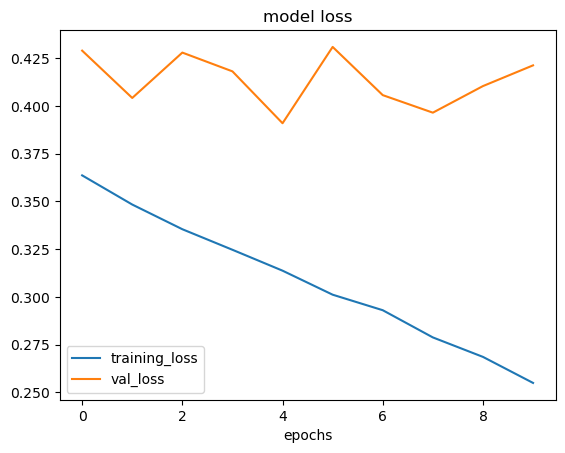

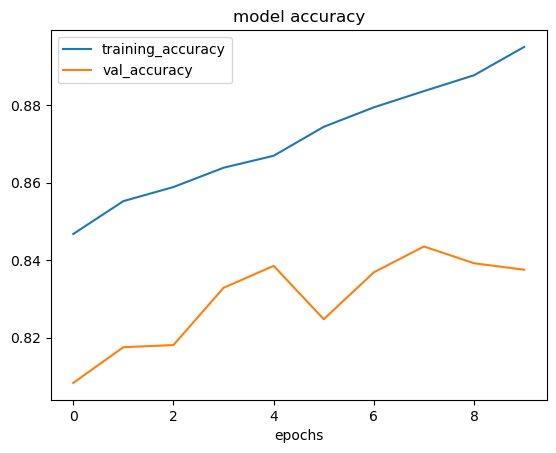

In [41]:
plot_loss_curves(history_1_nor)

##### Prediction

1/1 [==============================] - 0s 26ms/step
Predicted Value Using CNN Model: 1
True Value: 1


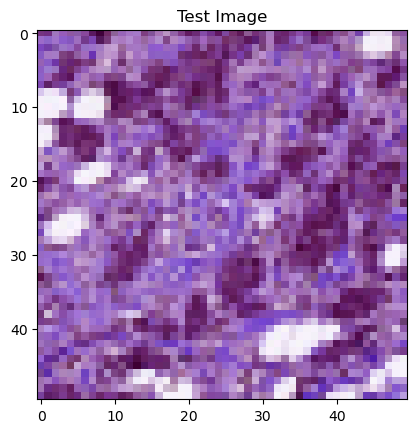

In [42]:
y_pred_1_nor = model_1.predict(X_test_nor)
y_true_1_nor = np.argmax(y_test_nor,axis = 1)
img_pred(X_test_nor,y_test_nor,300,model_1)

1/1 [==============================] - 0s 22ms/step
Predicted Value Using CNN Model: 1
True Value: 1


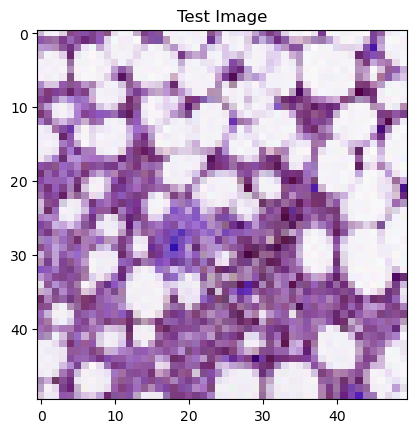

In [43]:
img_pred(X_test_nor,y_test_nor,3000,model_1)

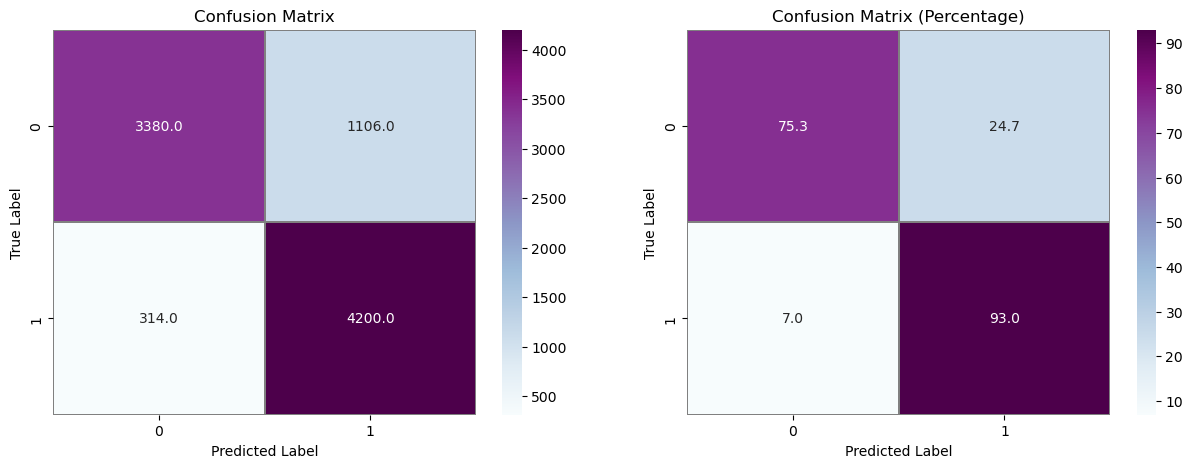

In [44]:
visualize_conf_mat(y_true_1_nor,y_pred_1_nor)

In [45]:
print(classification_report(y_true_1_nor, np.argmax(y_pred_1_nor,axis = 1)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.83      4486
           1       0.79      0.93      0.86      4514

    accuracy                           0.84      9000
   macro avg       0.85      0.84      0.84      9000
weighted avg       0.85      0.84      0.84      9000



### Model 2 (Less complex than Model 1)

In [46]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.3),
    Dense(24, activation='relu', kernel_initializer='he_uniform'),
    Dense(2, activation='softmax')
])

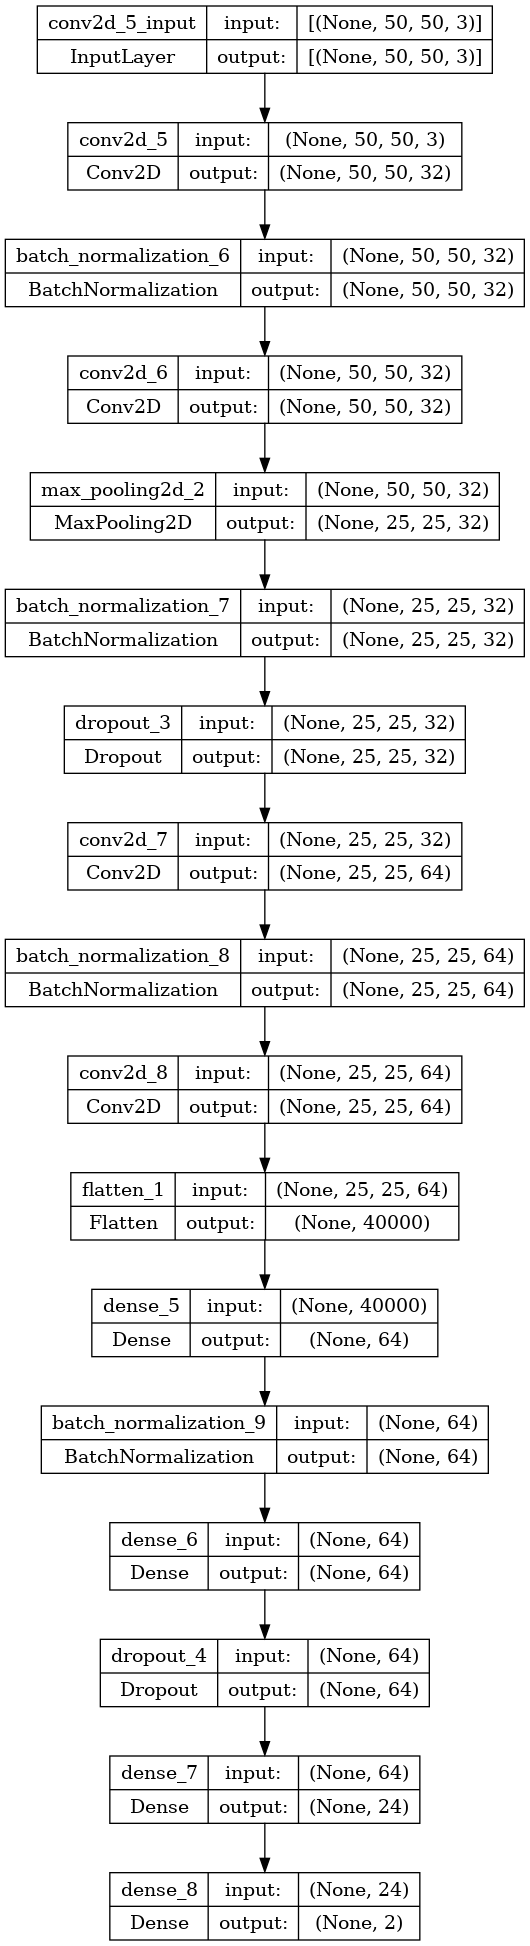

In [47]:
plot_model(model_2, to_file='model_2_hist.png', show_shapes=True)

#### Compile Model 2

In [48]:
model_2.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#### Fit Model 2 on Original Train Data

In [49]:
callbacks_or_2 = [EarlyStopping(monitor='val_loss', patience=10, verbose=1),ModelCheckpoint('model_or_2.hdf5',save_best_only=True)]

In [50]:
%time
history_2_or = model_2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 20, batch_size = 35, callbacks=callbacks_or_2)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs
Epoch 1/20


2023-06-14 08:55:54.857009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 21s 13ms/step - loss: 0.4512 - accuracy: 0.8047 - val_loss: 0.3925 - val_accuracy: 0.8293
Epoch 2/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.4000 - accuracy: 0.8281 - val_loss: 0.4130 - val_accuracy: 0.8159
Epoch 3/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.3770 - accuracy: 0.8398 - val_loss: 0.4052 - val_accuracy: 0.8282
Epoch 4/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.3589 - accuracy: 0.8450 - val_loss: 0.4713 - val_accuracy: 0.8111
Epoch 5/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.3419 - accuracy: 0.8536 - val_loss: 0.4110 - val_accuracy: 0.8308
Epoch 6/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.3169 - accuracy: 0.8658 - val_loss: 0.3983 - val_accuracy: 0.8337
Epoch 7/20
1200/1200 [==============================] - 15s 13ms/step - loss: 0.2969 - accuracy: 0.8719 - val_loss: 0.4200 - val_accura

#### Evaluate Model 2 on Original Test Data

In [51]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

282/282 [==============================] - 1s 5ms/step - loss: 0.4519 - accuracy: 0.8427
Test Loss: 0.4518745243549347
Test Accuracy: 0.8426666855812073


#### Original Data Results Visualization

##### Train

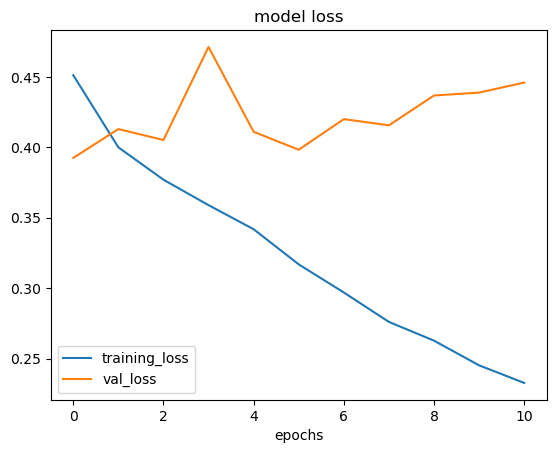

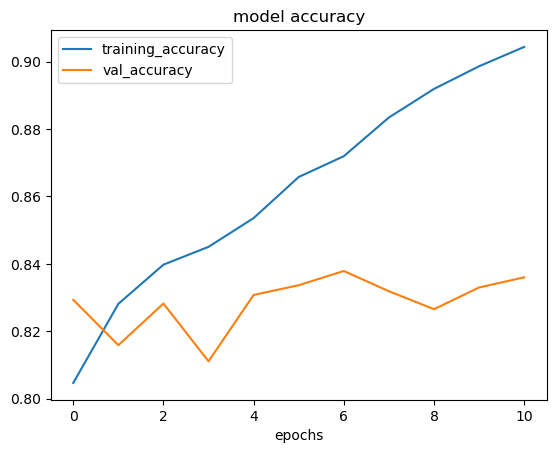

In [52]:
plot_loss_curves(history_2_or) # Plot our second history and see what happens on training process

##### Prediction

1/1 [==============================] - 0s 22ms/step
Predicted Value Using CNN Model: 1
True Value: 1


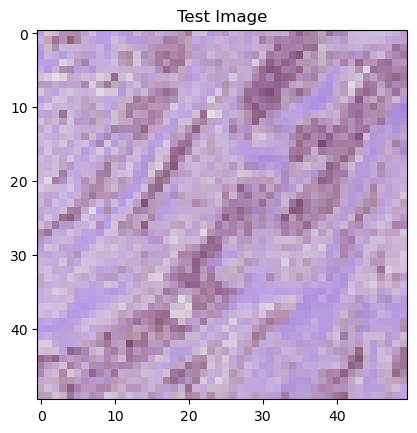

In [53]:
y_pred_2_or = model_2.predict(X_test) # Original test data prediction
y_true_2_or = np.argmax(y_test,axis = 1) # Original test data label
img_pred(X_test,y_test,300,model_2) # Let's see one random prediction on original test data

1/1 [==============================] - 0s 22ms/step
Predicted Value Using CNN Model: 0
True Value: 0


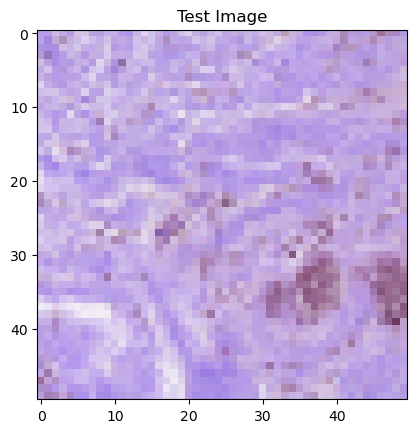

In [54]:
img_pred(X_test,y_test,6000,model_2)

1/1 [==============================] - 0s 20ms/step
Predicted Value Using CNN Model: 0
True Value: 0


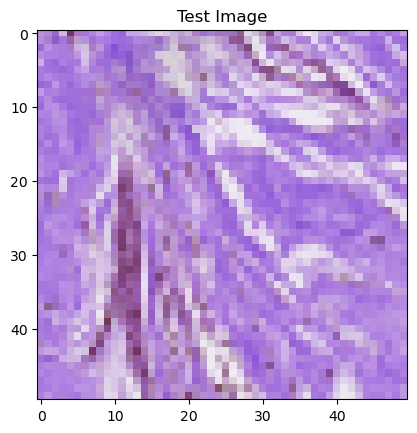

In [55]:
img_pred(X_test,y_test,3000,model_2)

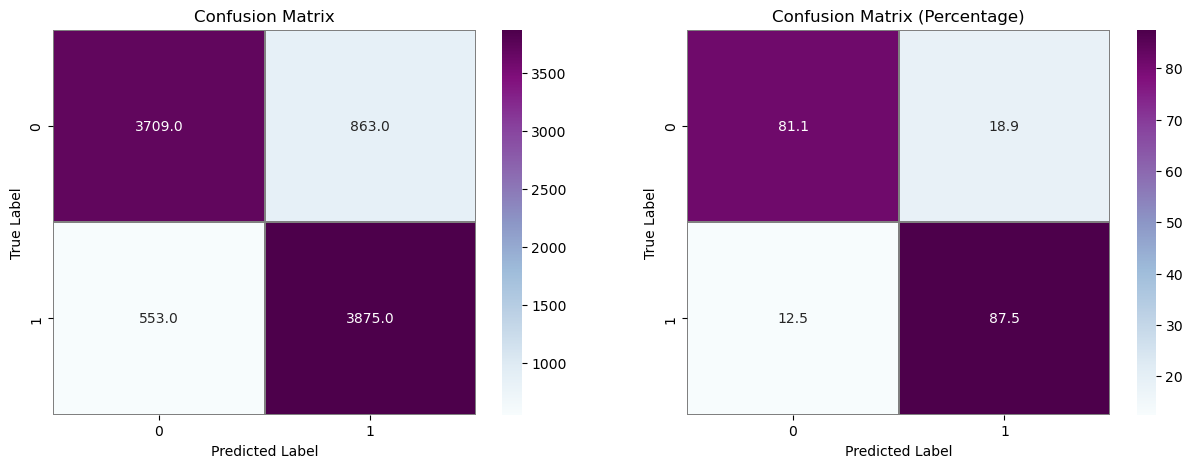

In [56]:
visualize_conf_mat(y_true_2_or,y_pred_2_or) # Let's visualize confusion matrix

In [57]:
print(classification_report(y_true_2_or, np.argmax(y_pred_2_or,axis = 1)))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4572
           1       0.82      0.88      0.85      4428

    accuracy                           0.84      9000
   macro avg       0.84      0.84      0.84      9000
weighted avg       0.84      0.84      0.84      9000



#### Fit Model 2 on Normalized Train Data

In [58]:
callbacks_nor_2 = [EarlyStopping(monitor='val_loss', patience=10, verbose=1),ModelCheckpoint('model_2_nor.hdf5',save_best_only=True)]

In this part my RAM was full and code cells doesnt worked but I donwloaded all files from kaggle directory so I upload normalized data on kaggle to continue with fresh directory.

In [59]:
import numpy as np
import os

input_path = '/kaggle/input/normalized-hist-data'

# Load a .npy file from a specific directory
file_path = os.path.join(input_path, 'X_train_nor.npy')  # Specify the desired directory index
X_train_nor = np.load(file_path)
file_path = os.path.join(input_path, 'X_test_nor.npy')  # Specify the desired directory index
X_test_nor = np.load(file_path)
file_path = os.path.join(input_path, 'X_val_nor.npy')  # Specify the desired directory index
X_val_nor = np.load(file_path)
file_path = os.path.join(input_path, 'y_train_nor.npy')  # Specify the desired directory index
y_train_nor = np.load(file_path)
file_path = os.path.join(input_path, 'y_test_nor.npy')  # Specify the desired directory index
y_test_nor = np.load(file_path)
file_path = os.path.join(input_path, 'y_val_nor.npy')  # Specify the desired directory index
y_val_nor = np.load(file_path)

In [60]:
X_train_nor[1]

array([[[0.60773486, 0.39779007, 0.70718235],
        [0.5966851 , 0.38121548, 0.7016575 ],
        [0.54696137, 0.34254146, 0.73480666],
        ...,
        [0.54696137, 0.30939227, 0.6132597 ],
        [0.53038675, 0.28176796, 0.6243094 ],
        [0.6243094 , 0.41436467, 0.7016575 ]],

       [[0.6132597 , 0.38674036, 0.6906078 ],
        [0.5690608 , 0.33701658, 0.60221   ],
        [0.480663  , 0.23204422, 0.61878455],
        ...,
        [0.63535917, 0.4364641 , 0.72375697],
        [0.67403316, 0.48618788, 0.7292818 ],
        [0.67403316, 0.52486193, 0.7569061 ]],

       [[0.5690608 , 0.33149174, 0.6243094 ],
        [0.52486193, 0.31491715, 0.59116024],
        [0.55248624, 0.32596686, 0.6519337 ],
        ...,
        [0.5359116 , 0.28176796, 0.6685083 ],
        [0.6243094 , 0.40331495, 0.6906078 ],
        [0.61878455, 0.39779007, 0.6629835 ]],

       ...,

       [[0.4972376 , 0.23756908, 0.54696137],
        [0.54696137, 0.31491715, 0.64640886],
        [0.51933706, 0

In [61]:
%time
history_2_nor = model_2.fit(X_train_nor, y_train_nor, validation_data = (X_val_nor, y_val_nor), epochs = 20, batch_size = 35, callbacks=callbacks_nor_2)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs
Epoch 1/20


2023-06-14 09:00:02.338861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1200/1200 [==============================] - 18s 14ms/step - loss: 0.3963 - accuracy: 0.8347 - val_loss: 0.3566 - val_accuracy: 0.8526
Epoch 2/20
1200/1200 [==============================] - 16s 14ms/step - loss: 0.3508 - accuracy: 0.8525 - val_loss: 0.3967 - val_accuracy: 0.8367
Epoch 3/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.3252 - accuracy: 0.8651 - val_loss: 0.3868 - val_accuracy: 0.8441
Epoch 4/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.2916 - accuracy: 0.8798 - val_loss: 0.4367 - val_accuracy: 0.8242
Epoch 5/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.2623 - accuracy: 0.8919 - val_loss: 0.4098 - val_accuracy: 0.8359
Epoch 6/20
1200/1200 [==============================] - 16s 14ms/step - loss: 0.2294 - accuracy: 0.9060 - val_loss: 0.7573 - val_accuracy: 0.7721
Epoch 7/20
1200/1200 [==============================] - 16s 13ms/step - loss: 0.2084 - accuracy: 0.9145 - val_loss: 0.4515 - val_accura

#### Evaluate Model 2 on Original Test Data

In [62]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_2.evaluate(X_test_nor, y_test_nor)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

282/282 [==============================] - 1s 5ms/step - loss: 0.5146 - accuracy: 0.8361
Test Loss: 0.5146427154541016
Test Accuracy: 0.8361111283302307


#### Normalized Data Results Visualization

##### Train

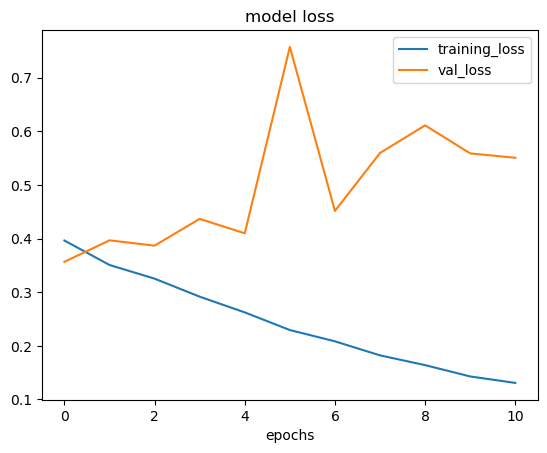

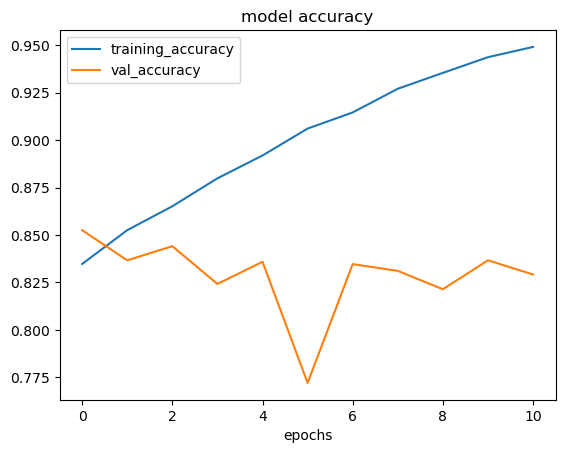

In [63]:
plot_loss_curves(history_2_nor) # Plot our second history of normalized data and see what happens on training process

##### Prediction

1/1 [==============================] - 0s 22ms/step
Predicted Value Using CNN Model: 1
True Value: 1


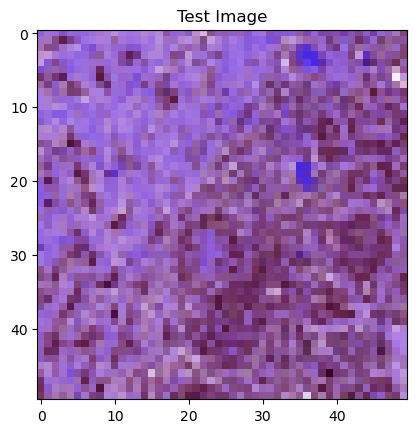

In [64]:
y_pred_2_nor = model_2.predict(X_test_nor) # Original test data prediction
y_true_2_nor = np.argmax(y_test_nor,axis = 1) # Original test data label
img_pred(X_test_nor,y_test_nor,300,model_2) # Let's see one random prediction on original test data

1/1 [==============================] - 0s 20ms/step
Predicted Value Using CNN Model: 1
True Value: 1


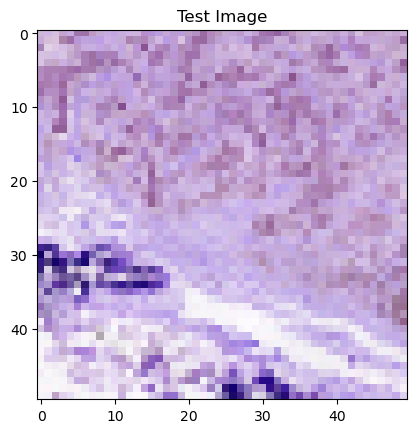

In [65]:
img_pred(X_test_nor,y_test_nor,6003,model_2)

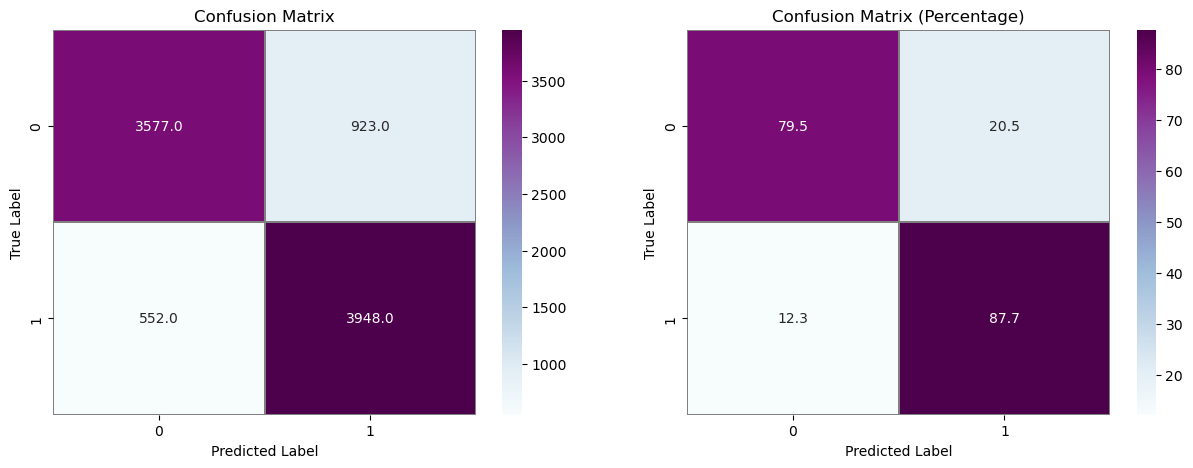

In [66]:
visualize_conf_mat(y_true_2_nor,y_pred_2_nor)

In [67]:
print(classification_report(y_true_2_nor, np.argmax(y_pred_2_nor,axis = 1)))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4500
           1       0.81      0.88      0.84      4500

    accuracy                           0.84      9000
   macro avg       0.84      0.84      0.84      9000
weighted avg       0.84      0.84      0.84      9000

